In [1]:
import json
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, meijering, sobel
from skimage.morphology import remove_small_objects, remove_small_holes, disk, binary_dilation, skeletonize
from skimage.exposure import rescale_intensity
from scipy.ndimage import map_coordinates
from skimage.restoration import inpaint
from scipy.ndimage import gaussian_filter
from itertools import groupby
from operator import itemgetter
from tifffile import imread
from dataclasses import dataclass, asdict
from typing import Optional
from skimage.transform import resize
from skimage.filters import frangi
from skimage.measure import label, regionprops
import networkx as nx
from scipy.spatial import cKDTree
from scipy.interpolate import splprep, splev

In [2]:
IMG_PATH = "../_images/C2-20250829_001448.tif"
OUT_CROP_COORDS = "crop_coords.json"
OUT_CROPPED = "cropped_capillary.tif"
OUT_MASK = "capillary_mask.tif"

PERC_LOW, PERC_HIGH = 1, 99       # percentiles for normalization
MEIJERING_SIGMAS = np.geomspace(1, 7, 5)  # vesselness scales (user used these)
MIN_OBJECT_SIZE = 200            # remove tiny speckles (increase for high-res)
BG_SIGMA = 60                     # gaussian sigma for background estimation (>> vessel width)
DILATE_RADIUS = 1                 # small dilation to ensure vessels are masked
VERT_THRESHOLD_FACTOR = 1.1       # vertical projection threshold factor (mean + factor*std)
HORIZ_PERCENTILE = 50             # horizontal detection fallback percentile
HORIZ_MARGIN_PIX = 2000           # fallback horizontal crop half-width if needed
VERT_MARGIN_FRAC = 0.12           # fraction of band height to expand vertically

image shape: (12240, 16320)


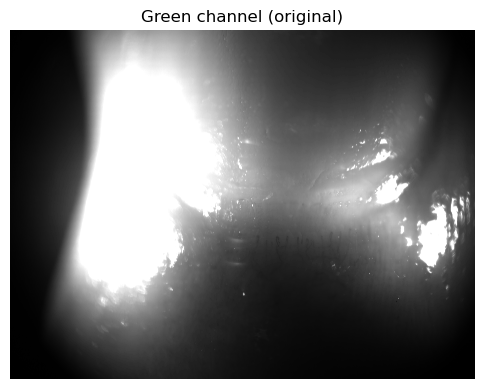

In [3]:
img_path = Path(IMG_PATH)
image = imread((img_path))
if image is None:
    raise FileNotFoundError(f"Could not load image at {IMG_PATH}. Run from notebook where file exists.")

h, w = image.shape
print("image shape:", image.shape)

plt.figure(figsize=(6,6))
plt.title("Green channel (original)")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

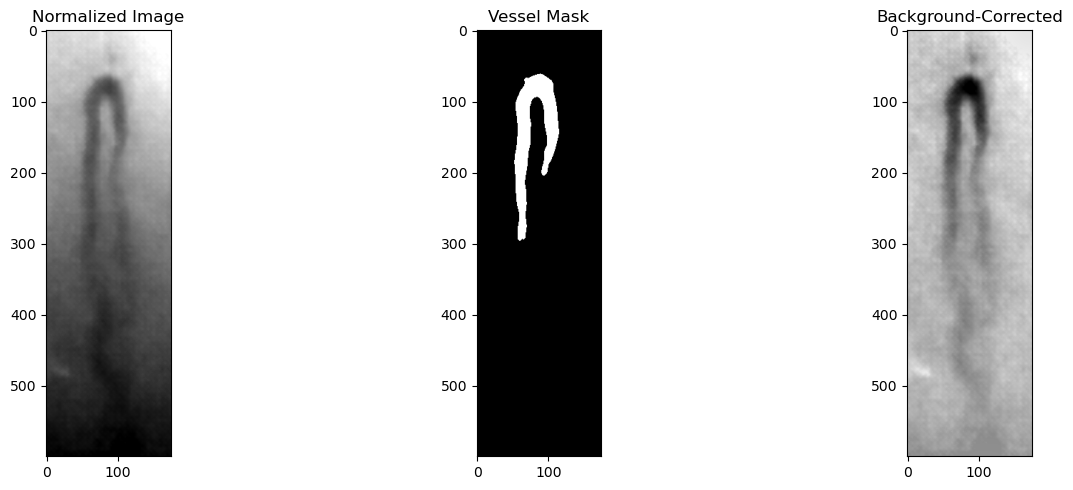

In [4]:
cropped_img_1 = image[7200:7800, 10025:10200] 
img_crop = cropped_img_1.astype(np.float32)
p1, p99 = np.percentile(img_crop, (1, 99))
img_n = np.clip((img_crop - p1) / (p99 - p1 + 1e-8), 0, 1)

sigmas = np.geomspace(4, 9, 2)
vessel_resp = meijering(img_n, sigmas=sigmas, black_ridges=True)
vessel_resp = (vessel_resp - vessel_resp.min()) / (vessel_resp.max() - vessel_resp.min() + 1e-8)

BW = vessel_resp > threshold_otsu(vessel_resp)
BW = remove_small_objects(BW, min_size=300)
BW = remove_small_holes(BW, area_threshold=300)
BW = binary_dilation(BW, disk(1))

mask = BW.astype(bool)
img_inp = inpaint.inpaint_biharmonic(img_n, mask, channel_axis=None)
bg = gaussian_filter(img_inp, sigma=60)
img_corr = np.clip(img_n - bg + bg.mean(), 0, 1)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(img_n, cmap='gray')
axes[0].set_title('Normalized Image')
axes[0].axis('on')

axes[1].imshow(BW, cmap='gray')
axes[1].set_title('Vessel Mask')
axes[1].axis('on')

axes[2].imshow(img_corr, cmap='gray')
axes[2].set_title('Background-Corrected')
axes[2].axis('on')

plt.tight_layout()
plt.show()


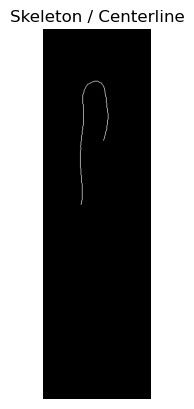

Number of centerline points: 311


In [5]:
BW_smooth = gaussian_filter(BW.astype(float), sigma=7)
skeleton = skeletonize(BW_smooth > 0.5)
centerline_coords_filter = []

plt.imshow(skeleton, cmap='gray')
plt.title("Skeleton / Centerline")
plt.axis('off')
plt.show()

centerline_coords = np.column_stack(np.nonzero(skeleton))
print("Number of centerline points:", len(centerline_coords))


In [6]:
# --- Step 1: Extract skeleton and keep largest connected branch ---
skeleton = skeletonize(BW)
labeled = label(skeleton)
regions = regionprops(labeled)
largest_region = max(regions, key=lambda r: r.area)
skeleton_largest = (labeled == largest_region.label)

coords = np.column_stack(np.nonzero(skeleton_largest))

# --- Step 2: Build skeleton graph and find longest path ---
tree = cKDTree(coords)
edges = []
for i, pt in enumerate(coords):
    neighbors_idx = tree.query_ball_point(pt, 1.5)  # connect neighbors within ~1.5 px
    for n in neighbors_idx:
        if n != i:
            edges.append((i, n))

G = nx.Graph()
G.add_edges_from(edges)
endpoints = [n for n, d in G.degree() if d == 1]

longest_path = []
max_len = 0
for i in range(len(endpoints)):
    for j in range(i+1, len(endpoints)):
        path = nx.shortest_path(G, endpoints[i], endpoints[j])
        if len(path) > max_len:
            max_len = len(path)
            longest_path = path

centerline_ordered = coords[longest_path]

dy: -1.778212259164576
dx: 0.8570803987935562
dy: -1.7199485178131226
dx: 0.9977415133589034
dy: -2.0941032704362215
dx: 0.09445203514991363
dy: -1.866128806948467
dx: 0.6448310767766969
dy: -1.6758004299387892
dx: 1.1043244258577403
dy: -2.009696968187967
dx: 0.2982268747872894
dy: -2.1481694665768316
dx: -0.0360753088386474
dy: -2.149939399060969
dx: -0.04034830384649979
dy: -1.887809670717445
dx: 0.5924888414214848
dy: -1.6687865399288455
dx: 1.1212574542448266
dy: -1.9808784325580575
dx: 0.36780097435290315
dy: -2.1506733532313547
dx: -0.0421202259587119
dy: -2.1521188710197237
dx: -0.04561001460822922
dy: -1.916258860302861
dx: 0.5238064220860252
dy: -1.6662608664880167
dx: 1.1273549693198675
dy: -1.9452308503942106
dx: 0.4538618506786065
dy: -2.183599659804429
dx: -0.1216113618464334
dy: -1.9618866541591728
dx: 0.41365118333686723
dy: -1.668663990750133
dx: 1.1215533141343315
dy: -1.8985175395941667
dx: 0.5666377591552703
dy: -2.1511958774146365
dx: -0.04338171092879861
dy: -2.14

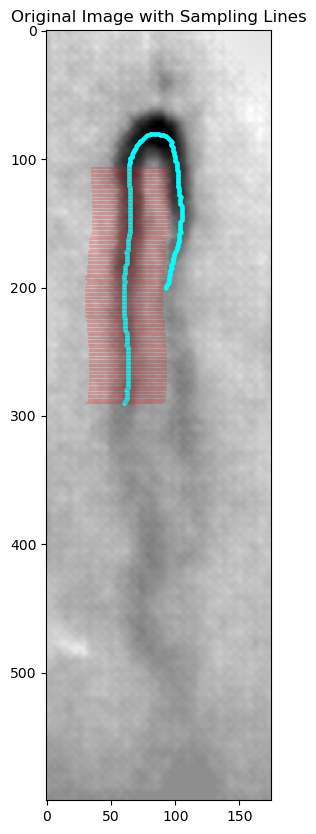

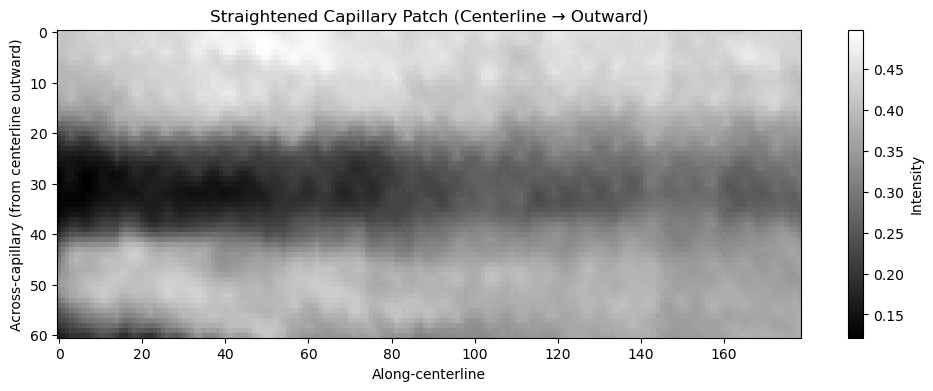

In [8]:
# --- Step 3: Resample centerline smoothly ---
tck, u = splprep([centerline_ordered[:,0], centerline_ordered[:,1]], s=0)
u_new = np.linspace(0, 1, len(centerline_ordered))
y_new, x_new = splev(u_new, tck)
centerline_resampled = np.column_stack([y_new, x_new])

# --- Step 4: Compute normals ---
normals = []
for i in range(1, len(centerline_resampled)-1):
    dy = centerline_resampled[i+1,0] - centerline_resampled[i-1,0]
    dx = centerline_resampled[i+1,1] - centerline_resampled[i-1,1]
    length = np.hypot(dx, dy)
    nx, ny = -dy/length, dx/length  
    normals.append([nx, ny])
    print("dy:", dy)
    print("dx:", dx)
normals.insert(0, normals[0])
normals.append(normals[-1])
normals = np.array(normals)

print(normals)

# --- Step 5: Straighten capillary ---
width = 30  
straight_capillary = []

plt.figure(figsize=(10,10))
plt.imshow(img_corr, cmap='gray')
plt.title("Original Image with Sampling Lines")

for (y, x), (nx, ny) in zip(centerline_resampled, normals):
    if x < 90 and y > 105:
        # if abs(ny) < 0.1:
        #     line_coords_y = y + np.arange(-width, width+1) * ny
        #     line_coords_x = x + np.arange(-width, width+1) * nx
        #     patch_line = map_coordinates(img_corr, [line_coords_y, line_coords_x], order=1)
        #     straight_capillary.append(patch_line)
        #     plt.plot(line_coords_x, line_coords_y, color='r', alpha=0.3, linewidth=0.5)
        #     ny_try = abs(ny)
        # else:
        #     line_coords_y = y + np.arange(-width, width+1) * 0.001
        #     line_coords_x = x + np.arange(-width, width+1) * nx
        #     patch_line = map_coordinates(img_corr, [line_coords_y, line_coords_x], order=1)
        #     straight_capillary.append(patch_line)
        #     plt.plot(line_coords_x, line_coords_y, color='r', alpha=0.3, linewidth=0.5)
        line_coords_y = np.full(2*width+1, y)
        line_coords_x = x + np.arange(-width, width+1) 
        patch_line = map_coordinates(img_corr, [line_coords_y, line_coords_x], order=1)
        straight_capillary.append(patch_line)
        plt.plot(line_coords_x, line_coords_y, color='r', alpha=0.3, linewidth=0.5)

plt.scatter(centerline_resampled[:,1], centerline_resampled[:,0], color='cyan', s=5)
plt.show()

straight_capillary = np.array(straight_capillary).T 

# --- Step 6: Visualization ---
plt.figure(figsize=(12,4))
plt.imshow(straight_capillary, cmap='gray', aspect='auto')
plt.title("Straightened Capillary Patch (Centerline → Outward)")
plt.xlabel("Along-centerline")
plt.ylabel("Across-capillary (from centerline outward)")
plt.colorbar(label='Intensity')
plt.show()


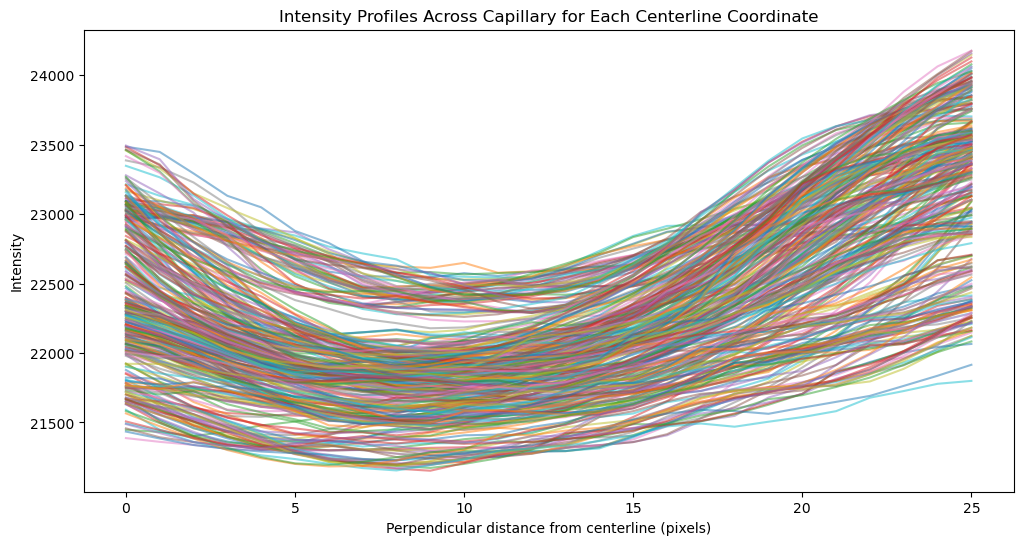

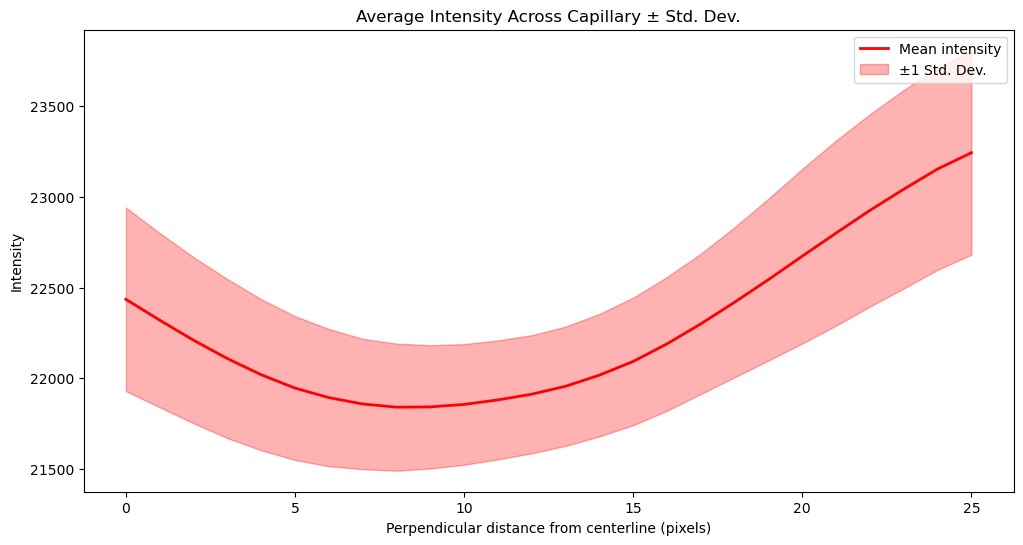

Lowest intensity profile occurs at centerline coordinate index = 339


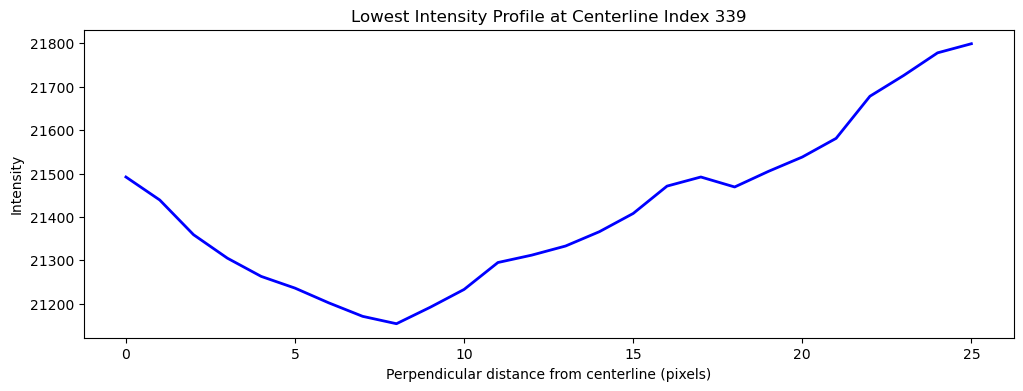

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# straight_capillary: shape (width+1, centerline_length)
width_plus_one, centerline_length = straight_capillary.shape

# --- Plot intensity for each centerline coordinate ---
plt.figure(figsize=(12,6))

for idx in range(centerline_length):
    plt.plot(np.arange(width_plus_one), straight_capillary[:, idx], alpha=0.5)

plt.xlabel("Perpendicular distance from centerline (pixels)")
plt.ylabel("Intensity")
plt.title("Intensity Profiles Across Capillary for Each Centerline Coordinate")
plt.show()

# --- Compute average and std across all centerline coordinates ---
avg_profile = straight_capillary.mean(axis=1)  # mean across centerline points
std_profile = straight_capillary.std(axis=1)   # std across centerline points

plt.figure(figsize=(12,6))
plt.plot(np.arange(width_plus_one), avg_profile, color='red', linewidth=2, label='Mean intensity')
plt.fill_between(
    np.arange(width_plus_one),
    avg_profile - std_profile,
    avg_profile + std_profile,
    color='red',
    alpha=0.3,
    label='±1 Std. Dev.'
)
plt.xlabel("Perpendicular distance from centerline (pixels)")
plt.ylabel("Intensity")
plt.title("Average Intensity Across Capillary ± Std. Dev.")
plt.legend()
plt.show()

# --- Find lowest intensity profile across perpendicular distance ---
line_sums = straight_capillary.sum(axis=0)  # sum along perpendicular distance for each centerline point
lowest_idx = np.argmin(line_sums)           # index along centerline with lowest total intensity
lowest_profile = straight_capillary[:, lowest_idx]

print(f"Lowest intensity profile occurs at centerline coordinate index = {lowest_idx}")
plt.figure(figsize=(12,4))
plt.plot(np.arange(width_plus_one), lowest_profile, color='blue', linewidth=2)
plt.xlabel("Perpendicular distance from centerline (pixels)")
plt.ylabel("Intensity")
plt.title(f"Lowest Intensity Profile at Centerline Index {lowest_idx}")
plt.show()


In [22]:
import numpy as np

# straight_capillary: shape (width+1, centerline_length)

# Find the minimum intensity value anywhere in the patch
min_intensity = avg_profile.min()
min_idx = np.unravel_index(np.argmin(avg_profile), avg_profile.shape)

print(f"Lowest intensity value: {min_intensity}")


Lowest intensity value: 21841.489855072465


In [ ]:
# %% Cell 3 (replace your current background_correct_and_mask)

EPS = 1e-6

def _mad(x):
    m = np.median(x)
    return np.median(np.abs(x - m)) + EPS

@dataclass
class VesselCalib:
    # Normalization frozen from ROI
    p1: float
    p99: float
    # Meijering config
    black_ridges: bool
    sig_lo: float
    sig_hi: float
    sig_n: int
    # Threshold expressed as robust z-score on resp: (t - median)/MAD
    tau_k: float
    # Background & morphology
    sigma_bg: float
    min_size: int = 100
    hole_area: int = 200
    dilate_r: int = 1

def calibrate_from_roi(roi,
                       sigma_bg: float = 60,
                       sig_lo: float = 3, sig_hi: float = 17, sig_n: int = 7,
                       polarity: str = 'dark') -> VesselCalib:
    """
    Learn vesselness + background correction settings from a representative ROI.
    polarity: 'dark' -> black_ridges=True, 'bright' -> False
    """
    roi = roi.astype(np.float32)
    p1, p99 = np.percentile(roi, (0.1, 99.9))
    A = (p99 - p1) + EPS
    roi_n = np.clip((roi - p1) / A, 0, 1)

    sigs = np.geomspace(sig_lo, sig_hi, sig_n)
    black_ridges = (polarity == 'dark')
    resp = meijering(roi_n, sigmas=sigs, black_ridges=black_ridges)

    t_roi = threshold_otsu(resp)
    med = np.median(resp)
    mad = _mad(resp)
    tau_k = (t_roi - med) / mad

    return VesselCalib(
        p1=p1, p99=p99,
        black_ridges=black_ridges,
        sig_lo=sig_lo, sig_hi=sig_hi, sig_n=sig_n,
        tau_k=tau_k,
        sigma_bg=sigma_bg
    )

# %%
# Keep same imports as before

# %%
# --- Function edits ---
def background_correct_capillaries(full_img,
                                   max_side: int = 3000,
                                   calib: Optional[VesselCalib] = None):
    """
    Vesselness-driven background correction.
    Improves capillary visibility while avoiding wave-like artifacts.
    """
    img = full_img.astype(np.float32)
    H, W = img.shape[:2]

    # --- Calibration params ---
    if calib is not None:
        p1, p99 = calib.p1, calib.p99
        black_ridges = calib.black_ridges
        sig_lo, sig_hi, sig_n = calib.sig_lo, calib.sig_hi, calib.sig_n
        sigma_bg = calib.sigma_bg
        min_size, hole_area, dilate_r = calib.min_size, calib.hole_area, calib.dilate_r
    else:
        p1, p99 = np.percentile(img, (1, 99))
        black_ridges = True
        sig_lo, sig_hi, sig_n = (3, 17, 7)
        sigma_bg = 60
        min_size, hole_area, dilate_r = 100, 200, 1

    # --- Step 1: rough normalization for vesselness ---
    A = (p99 - p1) + EPS
    img_n = np.clip((img - p1) / A, 0, 1)

    # --- Step 2: vesselness response on downsampled ---
    ds = min(1.0, max_side / max(H, W))
    h, w = int(H*ds), int(W*ds)
    img_small = resize(img_n, (h, w), order=1, preserve_range=True).astype(np.float32)

    sigs = np.geomspace(sig_lo, sig_hi, sig_n) * ds
    resp = meijering(img_small, sigmas=sigs, black_ridges=black_ridges)

    # --- Step 3: vessel mask ---
    if calib is None:
        t_s = threshold_otsu(resp)
    else:
        med_s, mad_s = np.median(resp), _mad(resp)
        t_s = med_s + calib.tau_k * mad_s

    BW = resp > t_s
    BW = remove_small_objects(BW, min_size=int(max(1, round(min_size * ds * ds))))
    BW = remove_small_holes(BW, area_threshold=int(max(1, round(hole_area * ds * ds))))
    BW = binary_dilation(BW, disk(max(1, int(round(dilate_r * ds)))))

    # --- Step 4: background estimation ---
    img_inp = inpaint.inpaint_biharmonic(img_small, BW, channel_axis=None)
    bg_small = gaussian_filter(img_inp, sigma=sigma_bg * ds)
    bg = resize(bg_small, (H, W), order=1, preserve_range=True).astype(np.float32)

    # --- Step 5: subtract background ---
    img_corr_raw = img - (bg * A + p1) + (bg.mean() * A + p1)

    # --- Step 6: vessel-aware contrast re-stretch ---
    # Use pixels outside vessel mask for percentile calc → avoids wave artifacts
    mask_inv = ~resize(BW, (H, W), order=0, preserve_range=True).astype(bool)
    vals = img_corr_raw[mask_inv]
    if len(vals) > 50:  # enough pixels
        p1c, p99c = np.percentile(vals, (1, 99))
    else:  # fallback to full image
        p1c, p99c = np.percentile(img_corr_raw, (1, 99))

    Ac = (p99c - p1c) + EPS
    img_corr_n = np.clip((img_corr_raw - p1c) / Ac, 0, 1)

    return img_n, img_corr_n, img_corr_raw, bg, BW, {"threshold_used": float(t_s)}

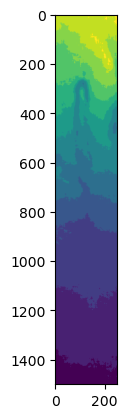

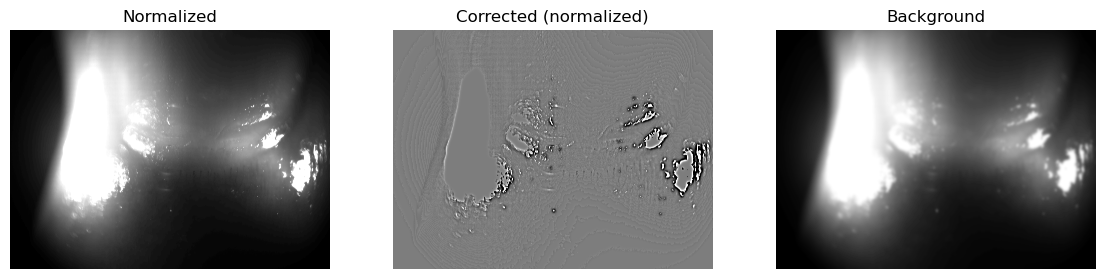

In [7]:
roi = green[7000:8500, 10000:10250]   
plt.imshow(roi)
calib = calibrate_from_roi(roi)

# Apply to full image
img_n, img_corr_n, img_corr_raw, bg, BW, meta = background_correct_capillaries(green, calib=None)

plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.title('Normalized'); plt.imshow(img_n, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('Corrected (normalized)'); plt.imshow(img_corr_n, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('Background'); plt.imshow(bg, cmap='gray'); plt.axis('off')
plt.show()


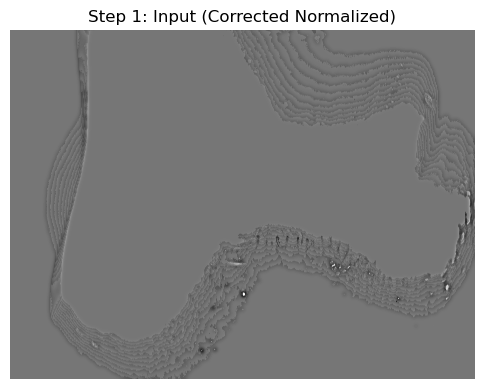

/var/folders/2y/v4w1xw5501g8rb1qrxtmtjj80000gn/T/ipykernel_57209/1714647182.py:11: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  vessels = frangi(img, scale_range=(3, 8), scale_step=2)


: 

In [32]:
# --- 1. Start with corrected normalized image ---
img = img_corr_n.copy()

plt.figure(figsize=(6,6))
plt.title("Step 1: Input (Corrected Normalized)")
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()

# --- 2. Enhance capillaries (Frangi filter = vesselness) ---
vessels = frangi(img, scale_range=(3, 8), scale_step=2)
plt.figure(figsize=(6,6))
plt.title("Step 2: Vesselness enhancement")
plt.imshow(vessels, cmap='gray')
plt.axis("off")
plt.show()

# --- 3. Threshold vessels to remove background ---
thresh = vessels > np.percentile(vessels, 90)   # top 10% pixels
plt.figure(figsize=(6,6))
plt.title("Step 3: Thresholded vessels")
plt.imshow(thresh, cmap='gray')
plt.axis("off")
plt.show()

# --- 4. Clean mask (remove speckles, fill holes) ---
mask = remove_small_objects(thresh, min_size=500)
mask = remove_small_holes(mask, area_threshold=500)
plt.figure(figsize=(6,6))
plt.title("Step 4: Cleaned vessel mask")
plt.imshow(mask, cmap='gray')
plt.axis("off")
plt.show()

# --- 5. Find bounding box of largest connected component ---
labeled = label(mask)
regions = regionprops(labeled)

if len(regions) > 0:
    largest = max(regions, key=lambda r: r.area)
    minr, minc, maxr, maxc = largest.bbox
    cropped = img[minr:maxr, minc:maxc]
else:
    print("No vessel region detected.")
    cropped = img

plt.figure(figsize=(6,6))
plt.title("Step 5: Cropped to capillary region")
plt.imshow(cropped, cmap='gray')
plt.axis("off")
plt.show()


In [16]:
# %% Cell 5: refine vessel enhancement on background-corrected image and make final mask
# re-run meijering on corrected image (smaller scales may help)
resp_corr = meijering(img_corr_n.astype(np.float32), sigmas=np.geomspace(1, 8, 6), black_ridges=True)
resp_corr = (resp_corr - resp_corr.min()) / (resp_corr.max() - resp_corr.min() + 1e-8)

# threshold and clean
try:
    th_corr = threshold_otsu(resp_corr)
except Exception:
    th_corr = np.mean(resp_corr) + 0.5 * np.std(resp_corr)
BW_corr = resp_corr > th_corr
BW_corr = remove_small_objects(BW_corr, min_size=int(MIN_OBJECT_SIZE/5))
BW_corr = remove_small_holes(BW_corr, area_threshold=int(MIN_OBJECT_SIZE/10))
BW_corr = binary_closing(BW_corr, disk(2))
BW_corr = binary_dilation(BW_corr, disk(1))
edges = cv2.Canny((img_corr_n*255).astype(np.uint8), 40, 100)
BW_corr = np.logical_or(BW_corr, edges>0)


plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.title('Meijering on corrected'); plt.imshow(resp_corr, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('Mask (refined)'); plt.imshow(BW_corr, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('Overlay'); 
overlay = cv2.cvtColor((rescale_intensity(img_corr, out_range=(0,255)).astype(np.uint8)), cv2.COLOR_GRAY2BGR)
overlay[BW_corr>0] = [0,255,0]  # green where mask
plt.imshow(overlay[:,:,::-1]); plt.axis('off')
plt.show()


KeyboardInterrupt: 

In [7]:
# %% Cell 6: find vertical and horizontal extents from the refined mask (longest consecutive segment)
mask_arr = (BW_corr > 0).astype(np.uint8)

# VERTICAL projection: pixels per row
v_proj = mask_arr.sum(axis=1)
v_mean, v_std = v_proj.mean(), v_proj.std()
v_thresh = v_mean + VERT_THRESHOLD_FACTOR * v_std
v_idx = np.where(v_proj > v_thresh)[0]

# fallback if weak: percentile cutoff
if len(v_idx) == 0:
    v_idx = np.where(v_proj >= np.percentile(v_proj, 60))[0]

if len(v_idx) == 0:
    # catastrophic fallback: use a centered vertical band heuristic (top half center)
    y_min = int(0.35 * h)
    y_max = int(0.55 * h)
else:
    # keep only the longest consecutive run
    consecutive = []
    for k, g in groupby(enumerate(v_idx), lambda x: x[0]-x[1]):
        seq = list(map(itemgetter(1), g))
        consecutive.append(seq)
    longest_seq = max(consecutive, key=len)
    y_min, y_max = longest_seq[0], longest_seq[-1]

band_h = max(1, y_max - y_min)

# HORIZONTAL projection
h_proj = mask_arr.sum(axis=0)
# try to find a strong horizontal band via percentile of the horizontal projection
h_idx = np.where(h_proj >= np.percentile(h_proj, HORIZ_PERCENTILE))[0]

if len(h_idx) > 0:
    # longest consecutive
    consecutive_h = []
    for k, g in groupby(enumerate(h_idx), lambda x: x[0]-x[1]):
        seq = list(map(itemgetter(1), g))
        consecutive_h.append(seq)
    longest_h = max(consecutive_h, key=len)
    x_min, x_max = longest_h[0], longest_h[-1]
else:
    # fallback: use glare center if exists, else image center
    _, glare_mask = cv2.threshold(green.astype(np.uint8), 25, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(glare_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        top_contour = min(contours, key=lambda c: cv2.boundingRect(c)[1])
        xg, yg, wg, hg = cv2.boundingRect(top_contour)
        cx = xg + wg // 2
    else:
        cx = w // 2
    # center around cx with fallback width
    half_w = HORIZ_MARGIN_PIX // 2
    x_min = max(cx - half_w, 0)
    x_max = min(cx + half_w, w)

# add margins
v_margin = int(VERT_MARGIN_FRAC * band_h)
y_min = max(y_min - v_margin, 0)
y_max = min(y_max + v_margin, h)
x_min = max(x_min - 200, 0)
x_max = min(x_max + 200, w)

print("CROP coords:", (y_min, y_max, x_min, x_max))


CROP coords: (np.int64(5773), np.int64(6823), np.int64(11575), np.int64(14320))


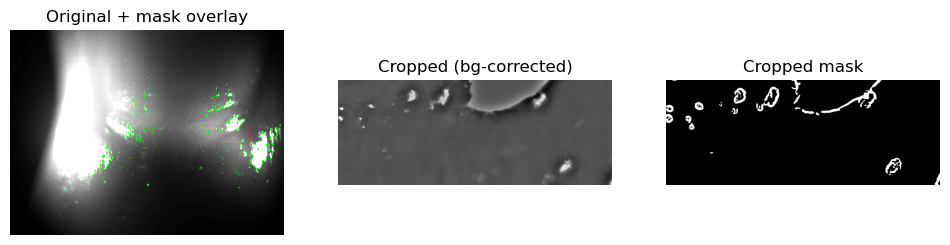

Saved crop coords -> crop_coords.json
Saved cropped image and mask.


In [8]:
# %% Cell 7: crop, visualize, and save outputs
cropped = (rescale_intensity(img_corr, out_range=(0,255)).astype(np.uint8))[y_min:y_max, x_min:x_max]
mask_cropped = mask_arr[y_min:y_max, x_min:x_max].astype(np.uint8) * 255

# overlay for QC
overlay_full = cv2.cvtColor(rescale_intensity(img_n, out_range=(0,255)).astype(np.uint8), cv2.COLOR_GRAY2BGR)
overlay_full[mask_arr > 0] = [0,255,0]
cv2.rectangle(overlay_full, (x_min, y_min), (x_max, y_max), (0,0,255), 6)

plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.title("Original + mask overlay"); plt.imshow(overlay_full[:,:,::-1]); plt.axis('off')
plt.subplot(1,3,2); plt.title("Cropped (bg-corrected)"); plt.imshow(cropped, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title("Cropped mask"); plt.imshow(mask_cropped, cmap='gray'); plt.axis('off')
plt.show()

# Save coords & outputs
coords = dict(y_min=int(y_min), y_max=int(y_max), x_min=int(x_min), x_max=int(x_max))
with open(OUT_CROP_COORDS, 'w') as f:
    json.dump(coords, f, indent=2)
print("Saved crop coords ->", OUT_CROP_COORDS)

# Save cropped image and mask (use appropriate dtype)
tifffile.imwrite(OUT_CROPPED, (cropped).astype(np.uint8))
tifffile.imwrite(OUT_MASK, (mask_cropped).astype(np.uint8))
print("Saved cropped image and mask.")
